In [1]:
# The program here first cleans the TCGA-BRCA data, matching RPPA data with mRNA data. 
# Then, we divide the dataset into two groups by differential levels of p-SHP2 and compare the differential expression genes. 
# Next, we also divide the dataset into two groups by differential levels of SHP2 and compare the same group of differential expression genes. 
# Finally, plot the data with heat maps. 

In [2]:
# import all the packages used in this study
%matplotlib notebook
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib as mpl
mpl.get_backend()
import matplotlib.pyplot as plt
import re

# import the raw_datasets
df_clinic=pd.read_csv("clinical_raw.csv", dtype=str).transpose()
df_mRNA=pd.read_csv("mRNA_raw.csv",dtype=str).dropna().transpose()
df_RPPA=pd.read_csv("RPPA_raw.csv",dtype=str).dropna().transpose()

# reset the header of each raw_datasets
df_clinic.columns=df_clinic.iloc[0]
df_clinic=df_clinic.drop("admin.batch_number", axis=0)
df_mRNA.columns=df_mRNA.iloc[0]
df_mRNA=df_mRNA.drop("Hybridization REF", axis=0).reset_index()
df_mRNA=df_mRNA.rename({"index":"Hybridization REF"}, axis="columns")
df_mRNA["Hybridization REF"]=[x.lower() for x in df_mRNA["Hybridization REF"]]
df_mRNA=df_mRNA.set_index("Hybridization REF")

df_RPPA.columns=df_RPPA.iloc[0]
df_RPPA=df_RPPA.drop("Composite.Element.REF",axis=0).reset_index()
df_RPPA=df_RPPA.rename({"index":"Composite.Element.REF"}, axis="columns")
df_RPPA["Composite.Element.REF"]=[x.lower() for x in df_RPPA["Composite.Element.REF"]]
df_RPPA=df_RPPA.set_index("Composite.Element.REF")

# select some columns interested in clinics data
col=["patient.samples.sample.portions.portion.analytes.analyte-2.aliquots.aliquot-2.bcr_aliquot_barcode", 
     "patient.samples.sample.portions.shipment_portion.shipment_portion_bcr_aliquot_barcode","patient.samples.sample.bcr_sample_barcode"]
df_clinic_sub=df_clinic[col]

# Rename the columns to fit the mRNA and RPPA datasets
df_clinic_sub=df_clinic_sub.rename({"patient.samples.sample.portions.portion.analytes.analyte-2.aliquots.aliquot-2.bcr_aliquot_barcode":
                                   "Hybridization REF","patient.samples.sample.portions.shipment_portion.shipment_portion_bcr_aliquot_barcode":
                                   "Composite.Element.REF"}, axis="columns")

# set index of selected clinic data and merge with mRNA dataset
df_merge=pd.merge(df_clinic_sub,df_mRNA, how="outer", on="Hybridization REF").dropna()
df_merge=df_merge.reset_index()
df_merge=df_merge.set_index("Composite.Element.REF")
df_merge=pd.merge(df_merge, df_RPPA, how="outer", on="Composite.Element.REF").dropna()
df_merge

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  return op.get_result()


,index,Hybridization REF,patient.samples.sample.bcr_sample_barcode,Composite Element REF,ELMO2,CREB3L1,RPS11,PNMA1,MMP2,C10orf90,...,CDKN1B|p27_pT157,CDKN1B|p27_pT198,MAPK14|p38_MAPK,MAPK14|p38_pT180_Y182,TP53|p53,SQSTM1|p62-LCK-ligand,RPS6KB1|p70S6K,RPS6KB1|p70S6K_pT389,RPS6KA1|p90RSK,RPS6KA1|p90RSK_pT359_S363
Composite.Element.REF,,,,,,,,,,,,,,,,,,,,,
tcga-bh-a0ea-01a-21-a13c-20,49.0,tcga-bh-a0ea-01a-11r-a115-07,tcga-bh-a0ea-01a,log2 lowess normalized (cy5/cy3) collapsed by ...,-0.604833333,1.20275,0.3035,-0.36625,1.187166667,-1.3675,...,-0.228381357,-0.333089444,-0.068365676,0.009476069,-1.123390328,-0.921933294,-0.445618366,-0.151993511,-0.334864763,0.071638985
tcga-bh-a18h-01a-21-a13f-20,50.0,tcga-bh-a18h-01a-11r-a12d-07,tcga-bh-a18h-01a,log2 lowess normalized (cy5/cy3) collapsed by ...,0.36925,0.8205,2.4975,-0.73025,-0.103666667,-2.45875,...,-0.021784682,0.011664654,0.341965269,0.203493004,0.264005656,0.42890725,0.125680239,-0.007199293,0.183334203,0.075611013
tcga-c8-a1hl-01a-21-a17j-20,53.0,tcga-c8-a1hl-01a-11r-a137-07,tcga-c8-a1hl-01a,log2 lowess normalized (cy5/cy3) collapsed by ...,0.573,2.633,0.236,-0.29025,0.628666667,-2.88375,...,0.004569226,-0.053229513,0.498370765,-0.420274353,-0.280243305,0.399689228,1.638963647,-0.266090285,0.23066662,0.595945589
tcga-d8-a146-01a-21-a13d-20,54.0,tcga-d8-a146-01a-31r-a115-07,tcga-d8-a146-01a,log2 lowess normalized (cy5/cy3) collapsed by ...,0.287083333,1.81775,-0.2945,0.599,1.728,-1.671,...,-0.11878716,-0.110126275,0.009863187,-0.358472283,-0.049301652,0.344797376,-0.127880664,-0.352134045,0.208897469,0.331329178
tcga-e2-a158-01a-21-a13e-20,55.0,tcga-e2-a158-01a-11r-a12d-07,tcga-e2-a158-01a,log2 lowess normalized (cy5/cy3) collapsed by ...,-0.613583333,-0.2965,1.737125,-0.747,-1.687166667,2.10775,...,0.124570666,-0.035025312,-0.165198563,-0.380797259,0.547262613,-1.193269322,-0.187083324,-0.218506722,0.220631428,0.248111217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tcga-e2-a1b1-01a-11-a13e-20,869.0,tcga-e2-a1b1-01a-21r-a12p-07,tcga-e2-a1b1-01a,log2 lowess normalized (cy5/cy3) collapsed by ...,1.15775,1.89825,0.35225,0.50025,2.484,-1.91425,...,0.308100866,0.088775106,0.128242936,0.876816983,-0.301321004,-0.122365316,0.473677851,-0.074594362,0.020735911,0.125236408
tcga-e2-a1b4-01a-21-a13e-20,870.0,tcga-e2-a1b4-01a-11r-a12p-07,tcga-e2-a1b4-01a,log2 lowess normalized (cy5/cy3) collapsed by ...,-0.351166667,1.71825,0.326125,-0.3635,0.400666667,-1.72625,...,0.001579647,-0.134038289,0.196523692,0.172802531,-0.289232527,-0.892198651,-0.206765754,-0.268250167,0.770893786,-0.57462026
tcga-e2-a1b5-01a-31-a13e-20,871.0,tcga-e2-a1b5-01a-21r-a12p-07,tcga-e2-a1b5-01a,log2 lowess normalized (cy5/cy3) collapsed by ...,-0.210416667,-0.07175,0.603625,-1.2445,-1.006,0.9515,...,-0.008807962,-0.382577402,0.580680963,0.357839435,-2.263861609,0.368440337,0.766563347,0.263891601,-0.627195208,-1.182336334


<IPython.core.display.Javascript object>


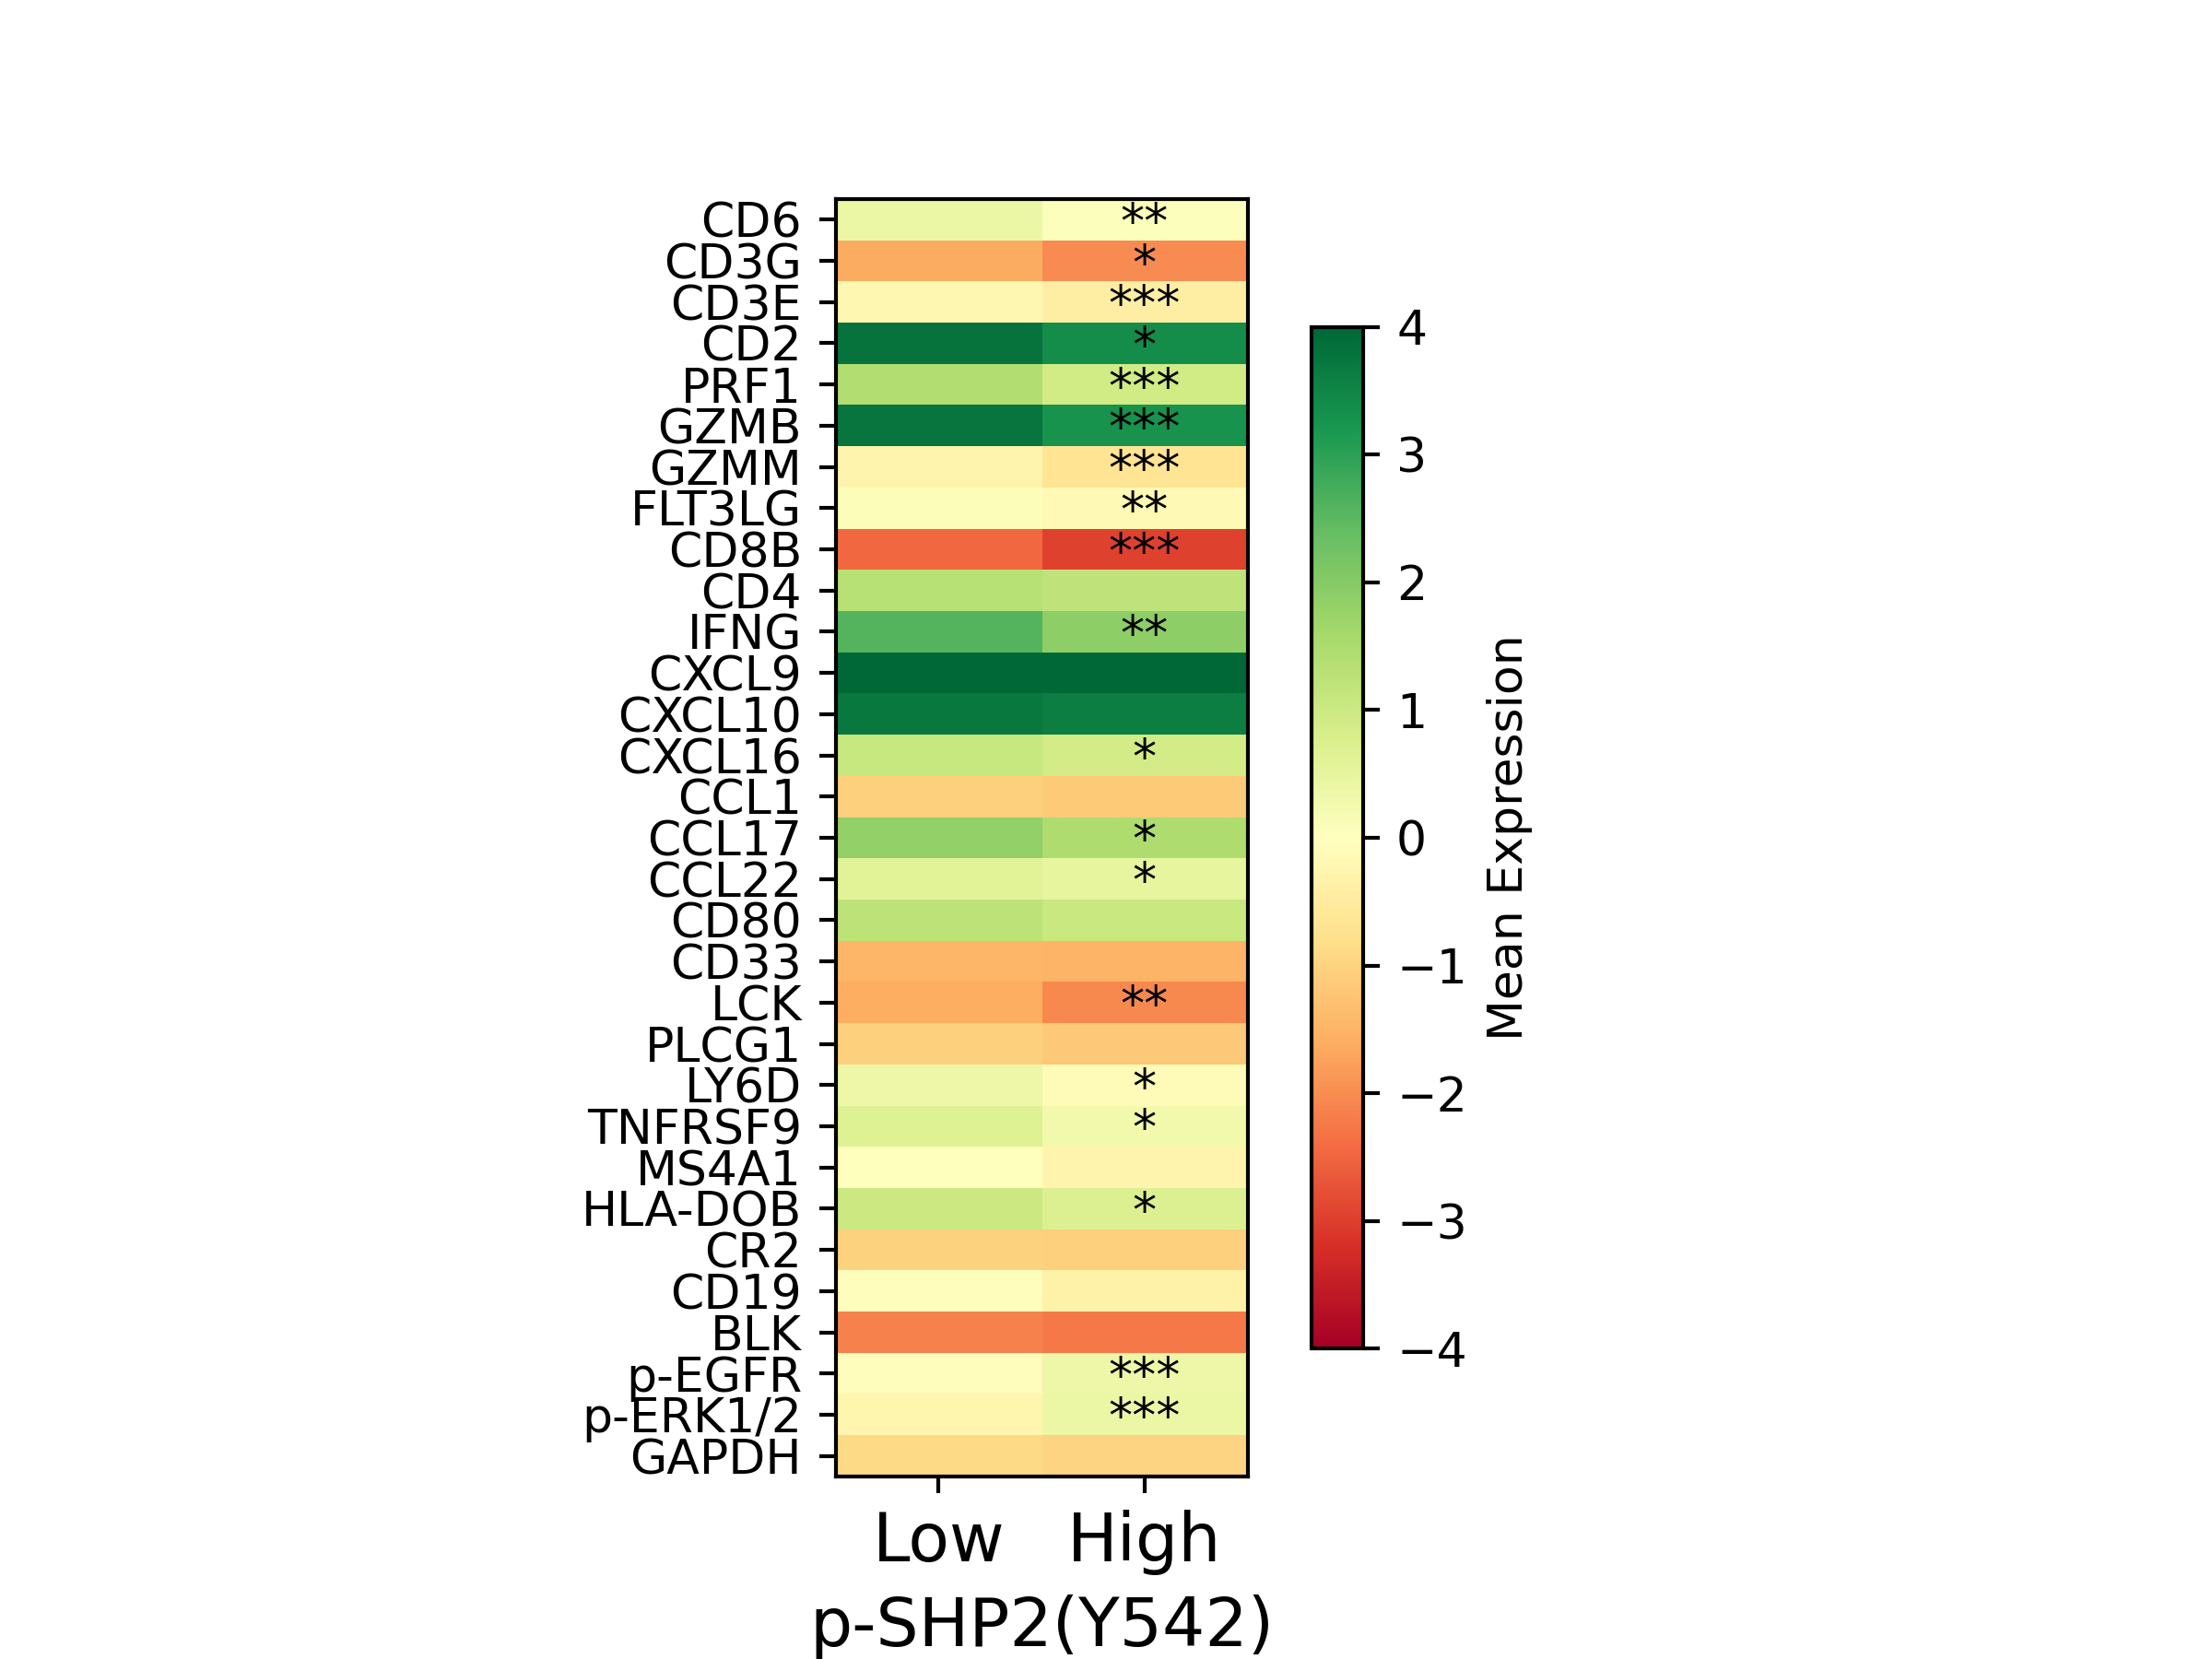

In [3]:
# select a list of interested genes, and make a subset of these genes, including levels of p-SHP2. 
ls=["CD6","CD3G","CD3E","CD2","PRF1","GZMB","GZMM","FLT3LG","CD8B", "CD4","IFNG",
    "CXCL9","CXCL10","CXCL16","CCL1","CCL17","CCL22","CD80","CD33","LCK",
       "PLCG1","LY6D","TNFRSF9","MS4A1","HLA-DOB","CR2","CD19","BLK","EGFR|EGFR_pY1068","MAPK1 MAPK3|MAPK_pT202_Y204","GAPDH"]
df_pSHP2=df_merge[ls+["PTPN11|SHP-2_pY542"]].astype(float)

# Divide the subsets into two groups according to the median of p-SHP2
div=np.median(df_pSHP2["PTPN11|SHP-2_pY542"])
df_pSHP2_low=df_pSHP2.where(df_pSHP2["PTPN11|SHP-2_pY542"]<=div).dropna()
df_pSHP2_high=df_pSHP2.where(df_pSHP2["PTPN11|SHP-2_pY542"]>div).dropna()

# calculate the difference (res1) and p-value (res2) of the t-test between the two groups of each genes. 
ls2=[]
ls3=[]
ls4=[]
def compare():
    for item in ls:
        x=stats.ttest_ind(df_pSHP2_low[item],df_pSHP2_high[item])[1]
        y=np.nanmean(df_pSHP2_low[item])
        z=np.nanmean(df_pSHP2_high[item])
        ls2.append(x)
        ls3.append(y)    
        ls4.append(z)
compare()
res=pd.DataFrame([ls,ls2,ls3,ls4])
res.columns=res.iloc[0]
res=res.drop(0)
res2=res[1:3].transpose().astype(float)
res2

# plot the heatmap
fig, ax = plt.subplots(dpi=300)
im = ax.imshow(res2,"RdYlGn", vmin=-4, vmax=4,aspect=0.2)
# We want to show all ticks...
ax.set_xticks([0,1])
ax.set_yticks(np.arange(len(ls)))
plt.subplots_adjust(left=0.1, right=0.68)
# ... and label them with the respective list entries
ax.set_xticklabels(["Low","High"],fontsize=14)
ls3=["CD6","CD3G","CD3E","CD2","PRF1","GZMB","GZMM","FLT3LG","CD8B", "CD4","IFNG",
    "CXCL9","CXCL10","CXCL16","CCL1","CCL17","CCL22","CD80","CD33","LCK",
       "PLCG1","LY6D","TNFRSF9","MS4A1","HLA-DOB","CR2","CD19","BLK","p-EGFR","p-ERK1/2","GAPDH"]
ax.set_yticklabels(ls3,fontsize=10)
fig.colorbar(im, label="Mean Expression",shrink=0.8)
fig.gca().set_xlabel("p-SHP2(Y542)",fontsize=14)
ls5=[]
for item in ls2:
    if item>=0.05:
        ls5.append("")
    if (item<0.05) & (item>=0.01):
        ls5.append("*")
    if (item<0.01) & (item>=0.001):
        ls5.append("**")
    if item<0.001:
        ls5.append("***")
for i in range(len(ls)):
        text = ax.text(1, i, ls5[i],
                       ha="center", va="center_baseline", color="black")


<IPython.core.display.Javascript object>


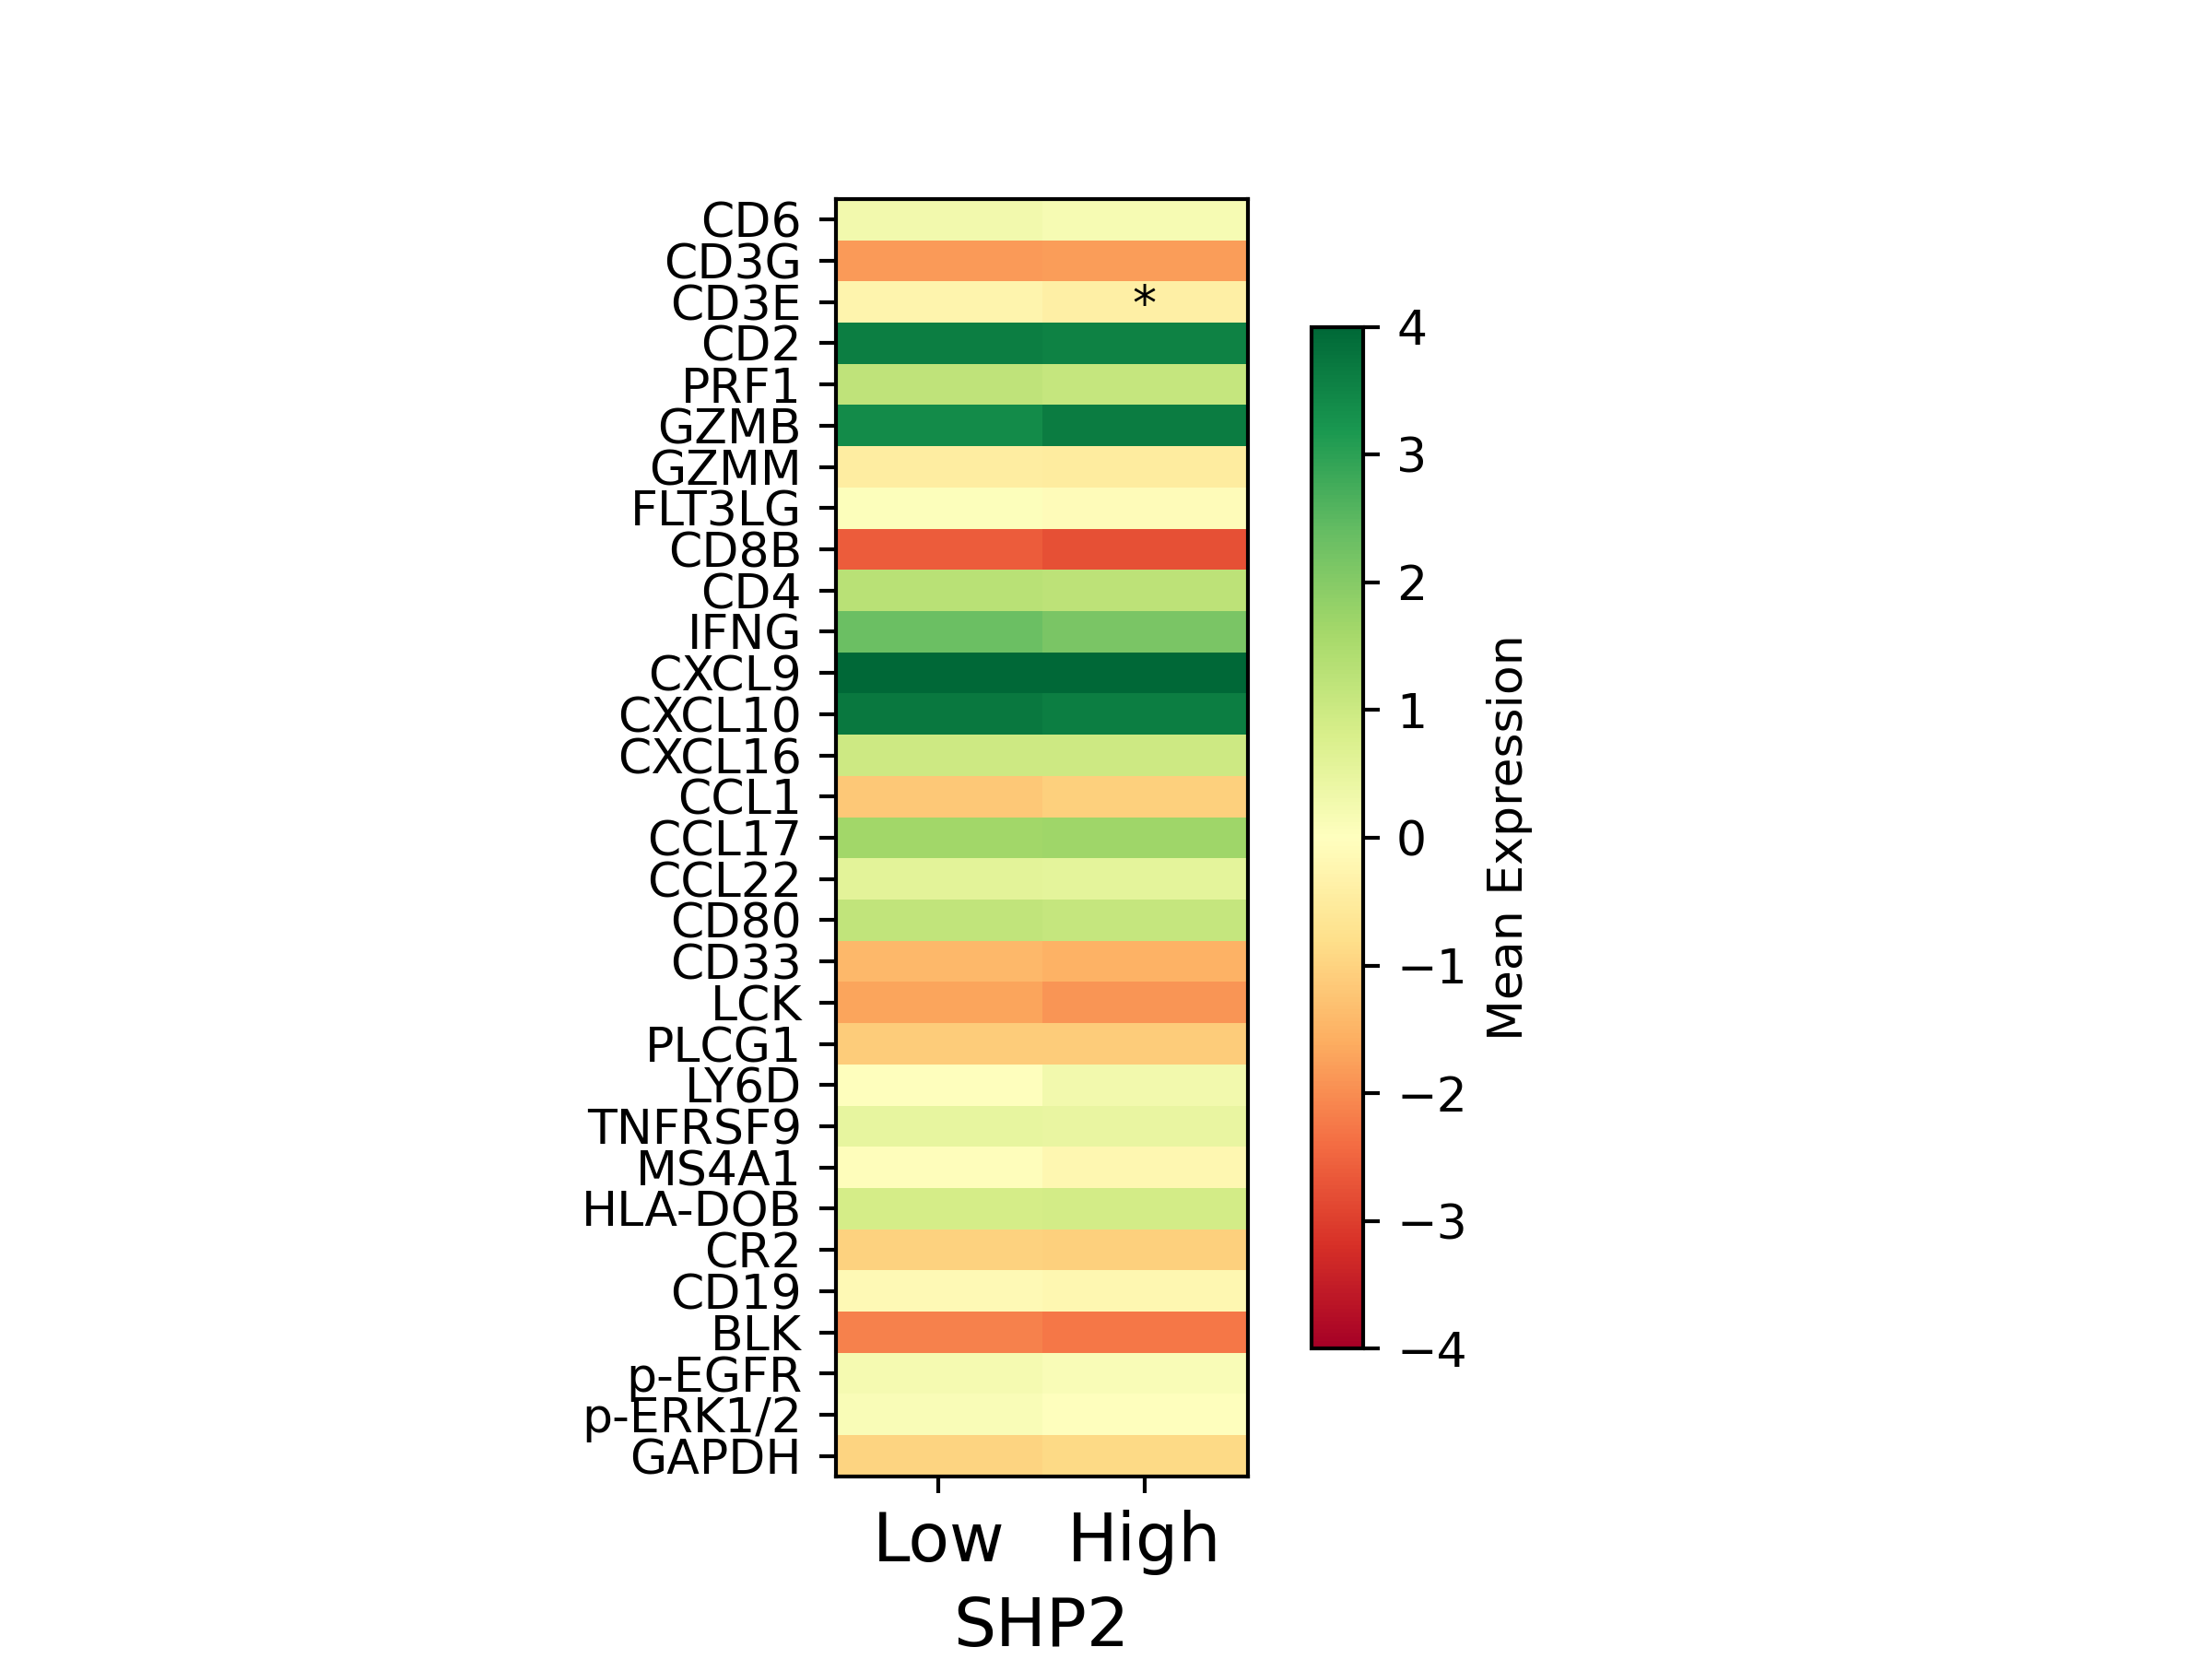

In [4]:
# select a list of interested genes, and make a subset of these genes, including levels of SHP2. 
ls=["CD6","CD3G","CD3E","CD2","PRF1","GZMB","GZMM","FLT3LG","CD8B", "CD4","IFNG",
    "CXCL9","CXCL10","CXCL16","CCL1","CCL17","CCL22","CD80","CD33","LCK",
       "PLCG1","LY6D","TNFRSF9","MS4A1","HLA-DOB","CR2","CD19","BLK","EGFR|EGFR_pY1068","MAPK1 MAPK3|MAPK_pT202_Y204","GAPDH"]
df_SHP2=df_merge[ls+["PTPN11"]].astype(float)

# Divide the subsets into two groups according to the median of SHP2
div=np.median(df_SHP2["PTPN11"])
df_SHP2_low=df_SHP2.where(df_SHP2["PTPN11"]<=div).dropna()
df_SHP2_high=df_SHP2.where(df_SHP2["PTPN11"]>div).dropna()
ls2=[]
ls3=[]
ls4=[]
def compare():
    for item in ls:
        x=stats.ttest_ind(df_SHP2_low[item],df_SHP2_high[item])[1]
        y=np.mean(df_SHP2_low[item])
        z=np.mean(df_SHP2_high[item])
        ls2.append(x)
        ls3.append(y)
        ls4.append(z)
compare()
res=pd.DataFrame([ls,ls2,ls3,ls4])
res.columns=res.iloc[0]
res=res.drop(0)
res2=res[1:3].transpose().astype(float)
res2
fig, ax = plt.subplots(dpi=300)
im = ax.imshow(res2,"RdYlGn", vmin=-4, vmax=4,aspect=0.2)
# We want to show all ticks...
ax.set_xticks([0,1])
ax.set_yticks(np.arange(len(ls)))
plt.subplots_adjust(left=0.1, right=0.68)
# ... and label them with the respective list entries
ax.set_xticklabels(["Low","High"],fontsize=14)
ls3=["CD6","CD3G","CD3E","CD2","PRF1","GZMB","GZMM","FLT3LG","CD8B", "CD4","IFNG",
    "CXCL9","CXCL10","CXCL16","CCL1","CCL17","CCL22","CD80","CD33","LCK",
       "PLCG1","LY6D","TNFRSF9","MS4A1","HLA-DOB","CR2","CD19","BLK","p-EGFR","p-ERK1/2","GAPDH"]
ax.set_yticklabels(ls3,fontsize=10)
fig.colorbar(im, label="Mean Expression",shrink=0.8)
fig.gca().set_xlabel("SHP2",fontsize=14)
ls5=[]
for item in ls2:
    if item>=0.05:
        ls5.append("")
    if (item<0.05) & (item>=0.01):
        ls5.append("*")
    if (item<0.01) & (item>=0.001):
        ls5.append("**")
    if item<0.001:
        ls5.append("***")
for i in range(len(ls)):
        text = ax.text(1, i, ls5[i],
                       ha="center", va="center_baseline", color="black")
        